### Newton's Law of Cooling - single ODE example
$$
\frac{dT}{dt} = -k \left(T - A\left(t\right)\right)
$$
Analytic solution:
$$
T\left(t\right) = A + \left(T_0 -A\right)e^{-kt}
$$

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import autograd.numpy as np # Autograd library allows for automatic differentiation of functions written in Python
from autograd import elementwise_grad as egrad

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

In [29]:
# Define the neural network model
class PINN_1layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer, self).__init__() # getting acess to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size) # Define the output layer

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)               # Output layer - no activation function
        x_ = initial_value + (x-initial_point_of_the_domain)*x_
        return x_

In [30]:
# Define the actual ODE function
def ode_function(T, k, A):
    # df/dx = ode_function
    # k - proportionality constant
    # A - (might be A(t)) environment temperature
    x = -k*(T - A)
    return x

In [31]:
# Define the analytic solution for the ODE
def analytic_solution(x, k, A, T0):
    # f(x) = ...
    # k - proportionality constant
    # A - (might be A(t)) environment temperature
    #x = A + (T0-A)*np.exp(-k*x)
    if torch.is_tensor(x):
        x = A + (T0 - A)*torch.exp(-k*x)
    else:
        x = A + (T0 - A)*np.exp(-k*x)
    return x

In [34]:
# Define the loss function for the PINN
def pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=False):
    # Convert the input numpy arrays to PyTorch tensors
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

    # Compute the predicted values of u for the collocation points
    u_pred_collocation = model(x_collocation_tensor) # our f(x)

    # Compute the derivative of u_pred_collocation with respect to x
    u_pred_derivative = torch.autograd.grad(u_pred_collocation, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation), create_graph=True)[0]

    # Compute the loss for the collocation points
    loss_collocation = torch.mean((u_pred_derivative - ode_function(analytic_solution(x_collocation_tensor, k, A, T0), k, A)) ** 2)

    # Total loss
    total_loss = loss_collocation
    
    if unsupervised_error: # we want to return also unsupervised error for each time step
        unsupervised_error = abs(u_pred_derivative - ode_function(analytic_solution(x_collocation_tensor, k, A, T0), k, A))
        return total_loss, unsupervised_error
    else:
        return total_loss

## Experiment number of neurons

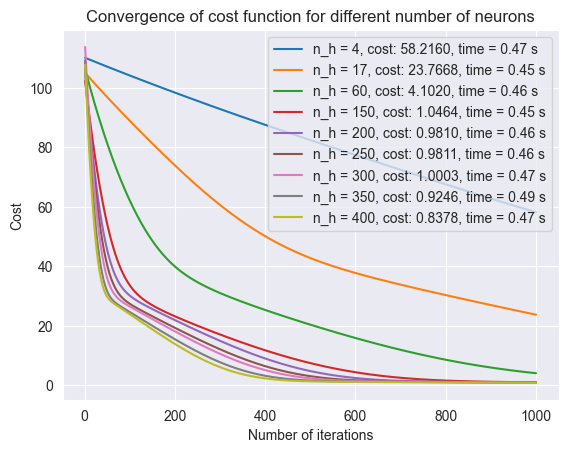

In [35]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
output_size = 1     # Dimension of the output (u)
initial_value = 0 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10
H = [4, 17, 60, 150, 200, 250, 300, 350, 400]  # different sizes for the hidden layer
 

for h in H:
    loss_per_iter = []
    hidden_size = h   # Number of units in the hidden layer
    
    # Create an instance of the PINN model
    model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # in article lr=0.001 as well

    start_time = time.time()  # start time
    
    # Training loop
    num_epochs = 1000 # in article - max 100 iter before convergance
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, k, A, T0)

        # Perform optimization
        loss.backward()
        optimizer.step()
        
        loss_per_iter.append(loss.item())  # loss after each iteration
        
    end_time = time.time()
    total_time = end_time - start_time

#         # Print progress
#         if (epoch + 1) % 100 == 0:
#             loss_per_iter.append(loss.item())
#             print(loss_per_iter)
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    plt.plot(number_of_iterations, loss_per_iter, label='n_h = {}, cost: {}, time = {} s'.format(h, '{:.4f}'.format(loss_per_iter[-1]), '{:.2f}'.format(total_time)))

plt.legend()
plt.title('Convergence of cost function for different number of neurons')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.show()

## Experiment number of layers

In [36]:
# Define the neural network model
class PINN_2layers(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_2layers, self).__init__() # getting acess to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size1)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size1, hidden_size2) # Define the hidden layer
        self.layer3 = nn.Linear(hidden_size2, output_size) # Define the output layer

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = torch.sigmoid(self.layer2(x_))
        x_ = self.layer3(x_)
        
        x_ = initial_value + (x-initial_point_of_the_domain)*x_
        return x_

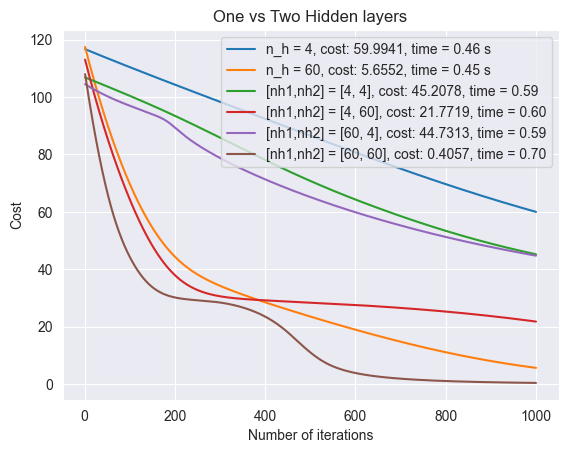

In [38]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
output_size = 1     # Dimension of the output (u)
initial_value = 0 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10
H = [4, 60]  # different sizes for the hidden
H1 = [4, 60]  # different sizes for the first hidden layer
H2 = [4, 60]  # different sizes for the second hidden layer
number_of_iterations = np.linspace(1, 1000, 1000)

for h in H:
    loss_per_iter = []
    hidden_size = h   # Number of units in the hidden layer
    
    # Create an instance of the PINN model
    model = PINN(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

    start_time = time.time()  # start time
    
    # Training loop
    num_epochs = 1000 # in article - max 100 iter before convergance
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, k, A, T0)

        # Perform optimization
        loss.backward()
        optimizer.step()
        
        loss_per_iter.append(loss.item())  # loss after each iteration
        
    end_time = time.time()
    total_time = end_time - start_time

#         # Print progress
#         if (epoch + 1) % 100 == 0:
#             loss_per_iter.append(loss.item())
#             print(loss_per_iter)
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    plt.plot(number_of_iterations, loss_per_iter, label='n_h = {}, cost: {}, time = {} s'.format(h, '{:.4f}'.format(loss_per_iter[-1]), '{:.2f}'.format(total_time)))
    
for h1 in H1:
    for h2 in H2:

        loss_per_iter = []
        hidden_size1 = h1   # Number of units in the 1st hidden layer
        hidden_size2 = h2  # Number of units in the 2nd hidden layer

        # Create an instance of the PINN model
        model = PINN_2layers(input_size, hidden_size1, hidden_size2, output_size, initial_value, initial_point_of_the_domain)

        # Define the collocation points
        x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article 

        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        start_time = time.time()  # start time

        # Training loop
        num_epochs = 1000 # as in article - max 100 iter
        for epoch in range(num_epochs):
            # Zero the gradients
            optimizer.zero_grad()

            # Compute the loss
            loss = pinn_loss(model, x_collocation, k, A, T0)

            # Perform optimization
            loss.backward()
            optimizer.step()

            loss_per_iter.append(loss.item())  # loss after each iteration

        end_time = time.time()
        total_time = end_time - start_time

    #         # Print progress
    #         if (epoch + 1) % 100 == 0:
    #             loss_per_iter.append(loss.item())
    #             print(loss_per_iter)
    #             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        plt.plot(number_of_iterations, loss_per_iter, label='[nh1,nh2] = {}, cost: {}, time = {}'.format([h1, h2], '{:.4f}'.format(loss_per_iter[-1]), '{:.2f}'.format(total_time)))
        
plt.legend()
plt.title('One vs Two Hidden layers')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.show()

## Implementation and comparison with analytical solution

In [65]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)
initial_value = 1 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10


# Create an instance of the PINN model
model = PINN(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article 

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss = pinn_loss(model, x_collocation, k, A, T0)

    # Perform optimization
    loss.backward()
    optimizer.step()

#   # Print progress
#   if (epoch + 1) % 100 == 0:
#   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(0, 1, 11).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred = u_pred_tensor.numpy()

# Compute the analytic solution for comparison
u_analytic = analytic_solution(x_test, k, A, T0)

# # Compare the neural network's output with the analytic solution
# print("Neural Network's Output:\n", u_pred)
# print("Analytic Solution:\n", u_analytic)

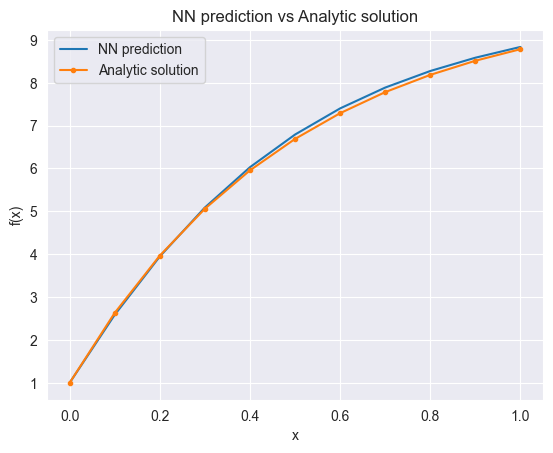

In [66]:
plt.plot(x_collocation, u_pred, label='NN prediction')
plt.plot(x_collocation, u_analytic, label='Analytic solution', marker=".")
plt.title('NN prediction vs Analytic solution')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend() 
plt.show()

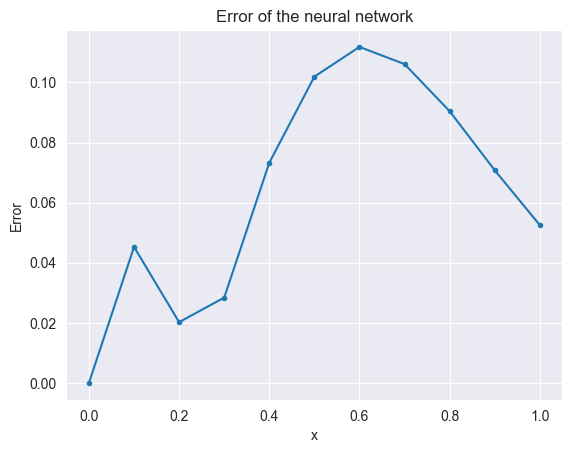

In [67]:
error = np.abs(u_pred - u_analytic)
plt.plot(x_collocation, error, marker='.')
plt.title('Error of the neural network')
plt.xlabel('x')
plt.ylabel('Error')
plt.show()

## Grid effect RK4 vs ANN

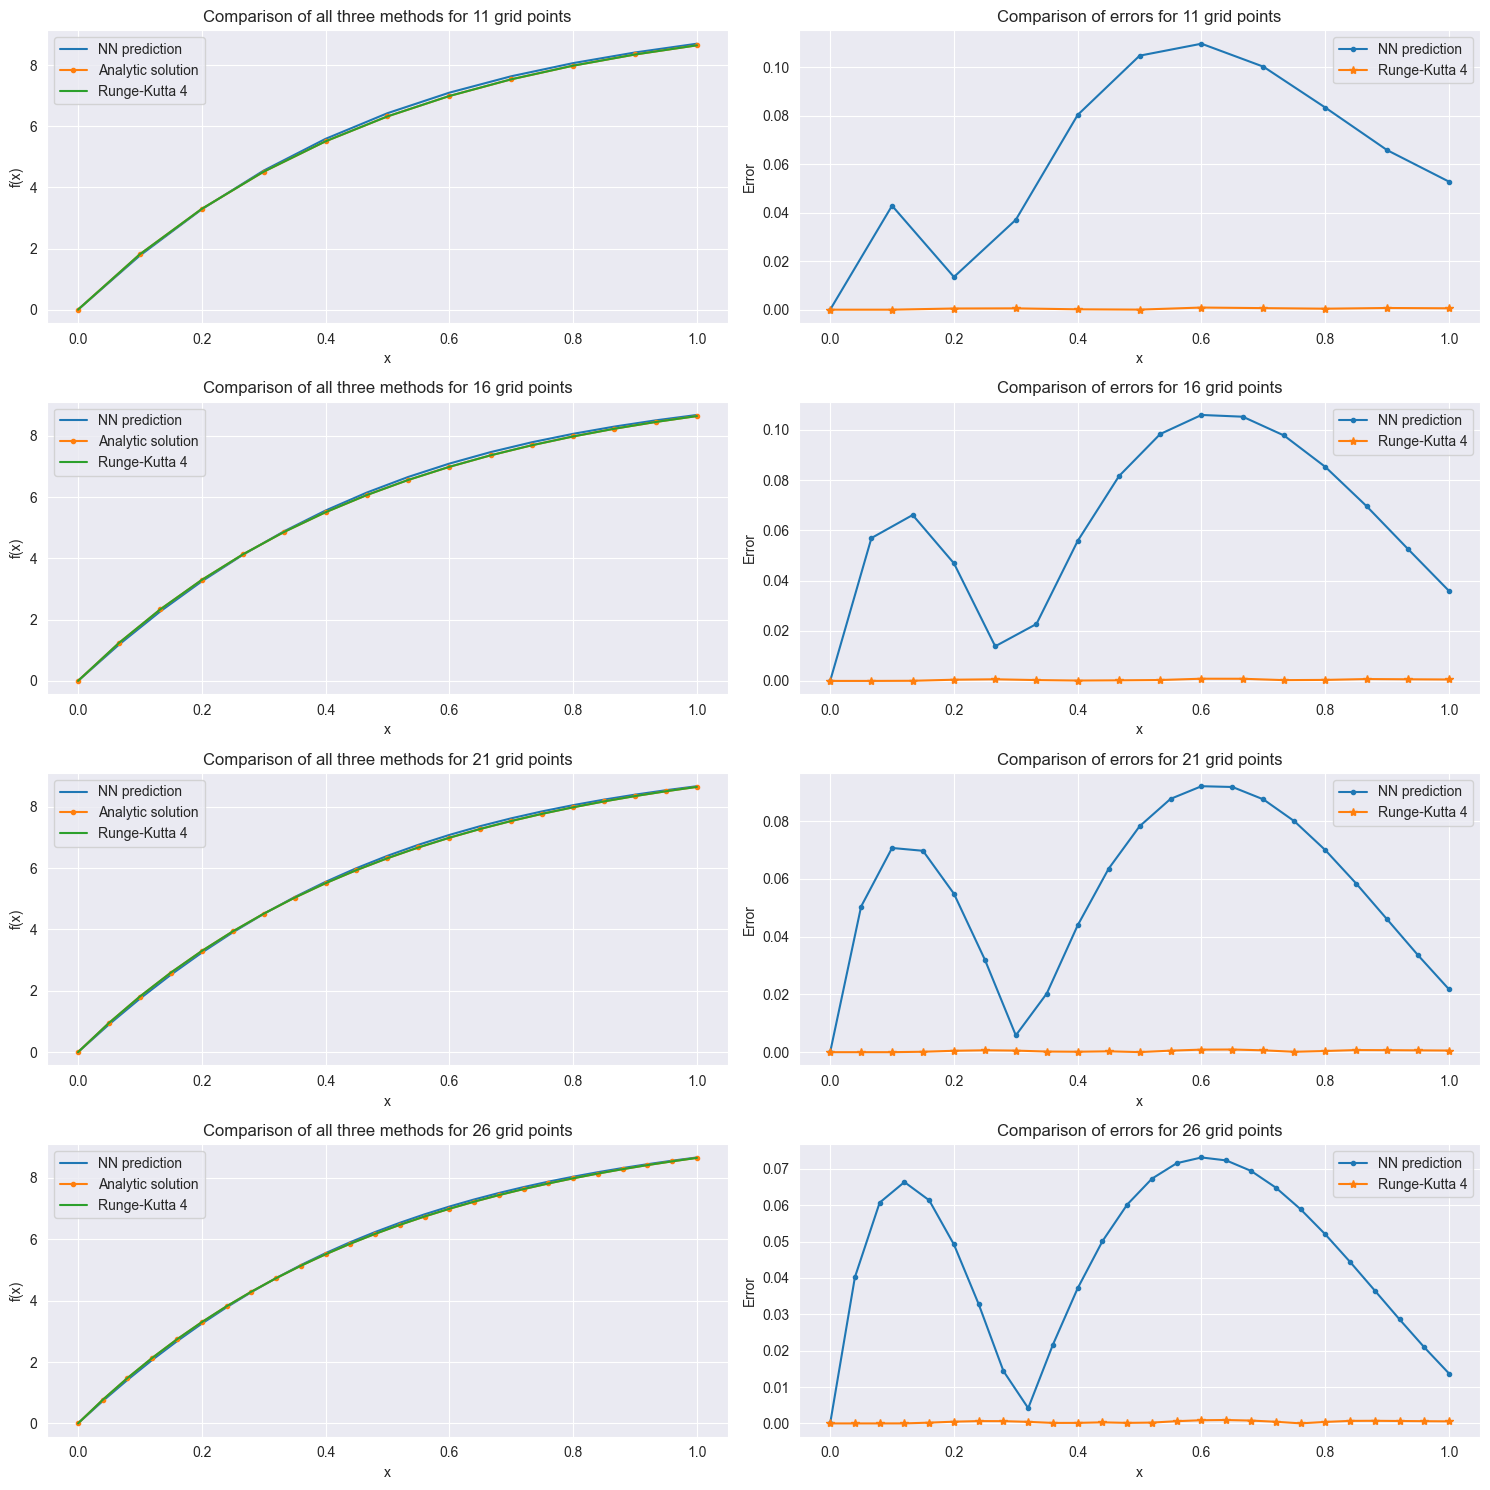

In [68]:
# diffent size of grid points between a and b.
M = [11, 16, 21, 26]
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)
initial_value = 0 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for ind, m in enumerate(M):
    # NN
    # Create an instance of the PINN model
    model = PINN(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(0, 1, m).reshape(-1, 1) # domain (0,1) - m sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

    # Training loop
    num_epochs = 3000 # as in the article
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, k, A, T0)

        # Perform optimization
        loss.backward()
        optimizer.step()

    #   # Print progress
    #   if (epoch + 1) % 100 == 0:
    #   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the trained model
    with torch.no_grad():
        # Generate test data
        x_test = np.linspace(0, 1, m).reshape(-1, 1)

        # Convert test data to PyTorch tensor
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

        # Compute the neural network's predictions
        u_pred_tensor = model(x_test_tensor)

        # Convert predictions to numpy array
        u_pred = u_pred_tensor.numpy()

    # Compute the analytic solution for comparison
    u_analytic = analytic_solution(x_test, k, A, T0)
    
    axs[ind,0].plot(x_collocation, u_pred, label='NN prediction')
    axs[ind,0].plot(x_collocation, u_analytic, label='Analytic solution', marker=".")
    
    
    # RK solution - numeric
    # Solve ODE using Runge-Kutta 4 (solve_ivp from scipy)
    tf = 1   # Final time
    
    sol = solve_ivp(fun=lambda t, y: ode_function(y, k, A),
                    t_span=(0, tf),
                    y0=[T0],
                    method='RK45',
                    t_eval=np.linspace(0, tf, m))
    axs[ind,0].plot(sol.t, sol.y[0], label='Runge-Kutta 4')
    axs[ind,0].legend()
    axs[ind,0].set_title('Comparison of all three methods for {} grid points'.format(m))
    axs[ind,0].set_xlabel('x')
    axs[ind,0].set_ylabel('f(x)')
    
    axs[ind,1].plot(x_collocation, abs(u_pred-u_analytic), label='NN prediction', marker='.')
    axs[ind,1].plot(sol.t, abs(sol.y[0]-[element for sublist in u_analytic for element in sublist]), label='Runge-Kutta 4', marker='*')
    axs[ind,1].legend()
    axs[ind,1].set_title('Comparison of errors for {} grid points'.format(m))
    axs[ind,1].set_xlabel('x')
    axs[ind,1].set_ylabel('Error')
    fig.tight_layout()

## For different activation functions

In [49]:
# Define the neural network model
class PINN_1layer_relu(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer_relu, self).__init__() # getting acess to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size) # Define the output layer

    def forward(self, x):
        x_ = torch.relu(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)               # Output layer - no activation function
        x_ = initial_value + (x-initial_point_of_the_domain)*x_
        return x_

In [55]:
# Define the neural network model
class PINN_1layer_leaky_relu(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer_leaky_relu, self).__init__() # getting acess to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size) # Define the output layer

    def forward(self, x):
        x_ = F.leaky_relu(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)               # Output layer - no activation function
        x_ = initial_value + (x-initial_point_of_the_domain)*x_
        return x_

In [51]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)
initial_value = 0 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10


# Create an instance of the PINN model
model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

unsupervised_error = []
# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss, unsupervised_error_per_epoch = pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=True)
    unsupervised_error.append(unsupervised_error_per_epoch)

    # Perform optimization
    loss.backward()
    optimizer.step()

#   # Print progress
#   if (epoch + 1) % 100 == 0:
#   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(0, 1, 11).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred = u_pred_tensor.numpy()

In [52]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)
initial_value = 0 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10


# Create an instance of the PINN model
model = PINN_1layer_relu(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

unsupervised_error_relu = []
# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss, unsupervised_error_relu_per_epoch = pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=True)
    unsupervised_error_relu.append(unsupervised_error_relu_per_epoch)

    # Perform optimization
    loss.backward()
    optimizer.step()

#   # Print progress
#   if (epoch + 1) % 100 == 0:
#   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(0, 1, 11).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred_relu = u_pred_tensor.numpy()

In [56]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)
initial_value = 0 # f(a) = initial_value
initial_point_of_the_domain = 0 # x in (a,b)
T0 = initial_value
k = 2
A = 10


# Create an instance of the PINN model
model = PINN_1layer_leaky_relu(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(0, 1, 11).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

unsupervised_error_leaky_relu = []
# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss, unsupervised_error_leaky_relu_per_epoch = pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=True)
    
    unsupervised_error_leaky_relu.append(unsupervised_error_leaky_relu_per_epoch)

    # Perform optimization
    loss.backward()
    optimizer.step()

#   # Print progress
#   if (epoch + 1) % 100 == 0:
#   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(0, 1, 11).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred_leaky_relu = u_pred_tensor.numpy()

In [57]:
# Compute the analytic solution for comparison
u_analytic = analytic_solution(x_test, k, A, T0)

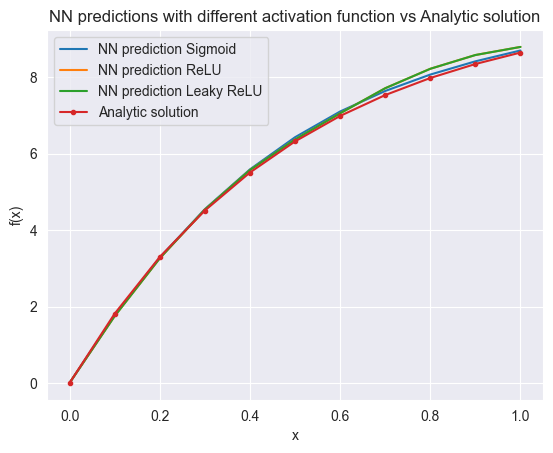

In [58]:
plt.plot(x_collocation, u_pred, label='NN prediction Sigmoid')
plt.plot(x_collocation, u_pred_relu, label='NN prediction ReLU')
plt.plot(x_collocation, u_pred_relu, label='NN prediction Leaky ReLU')
plt.plot(x_collocation, u_analytic, label='Analytic solution', marker=".")
plt.title('NN predictions with different activation function vs Analytic solution')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

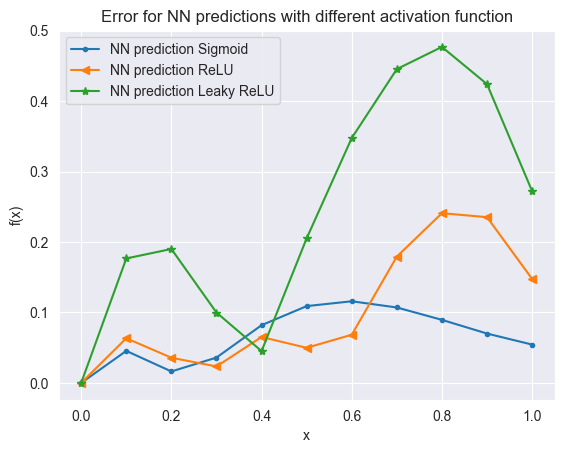

In [59]:
plt.plot(x_collocation, abs(u_pred-u_analytic), label='NN prediction Sigmoid', marker='.')
plt.plot(x_collocation, abs(u_pred_relu-u_analytic), label='NN prediction ReLU', marker="<")
plt.plot(x_collocation, abs(u_pred_leaky_relu-u_analytic), label='NN prediction Leaky ReLU', marker="*")
plt.title('Error for NN predictions with different activation function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

## Unsupervised error - does it make sense to study it?

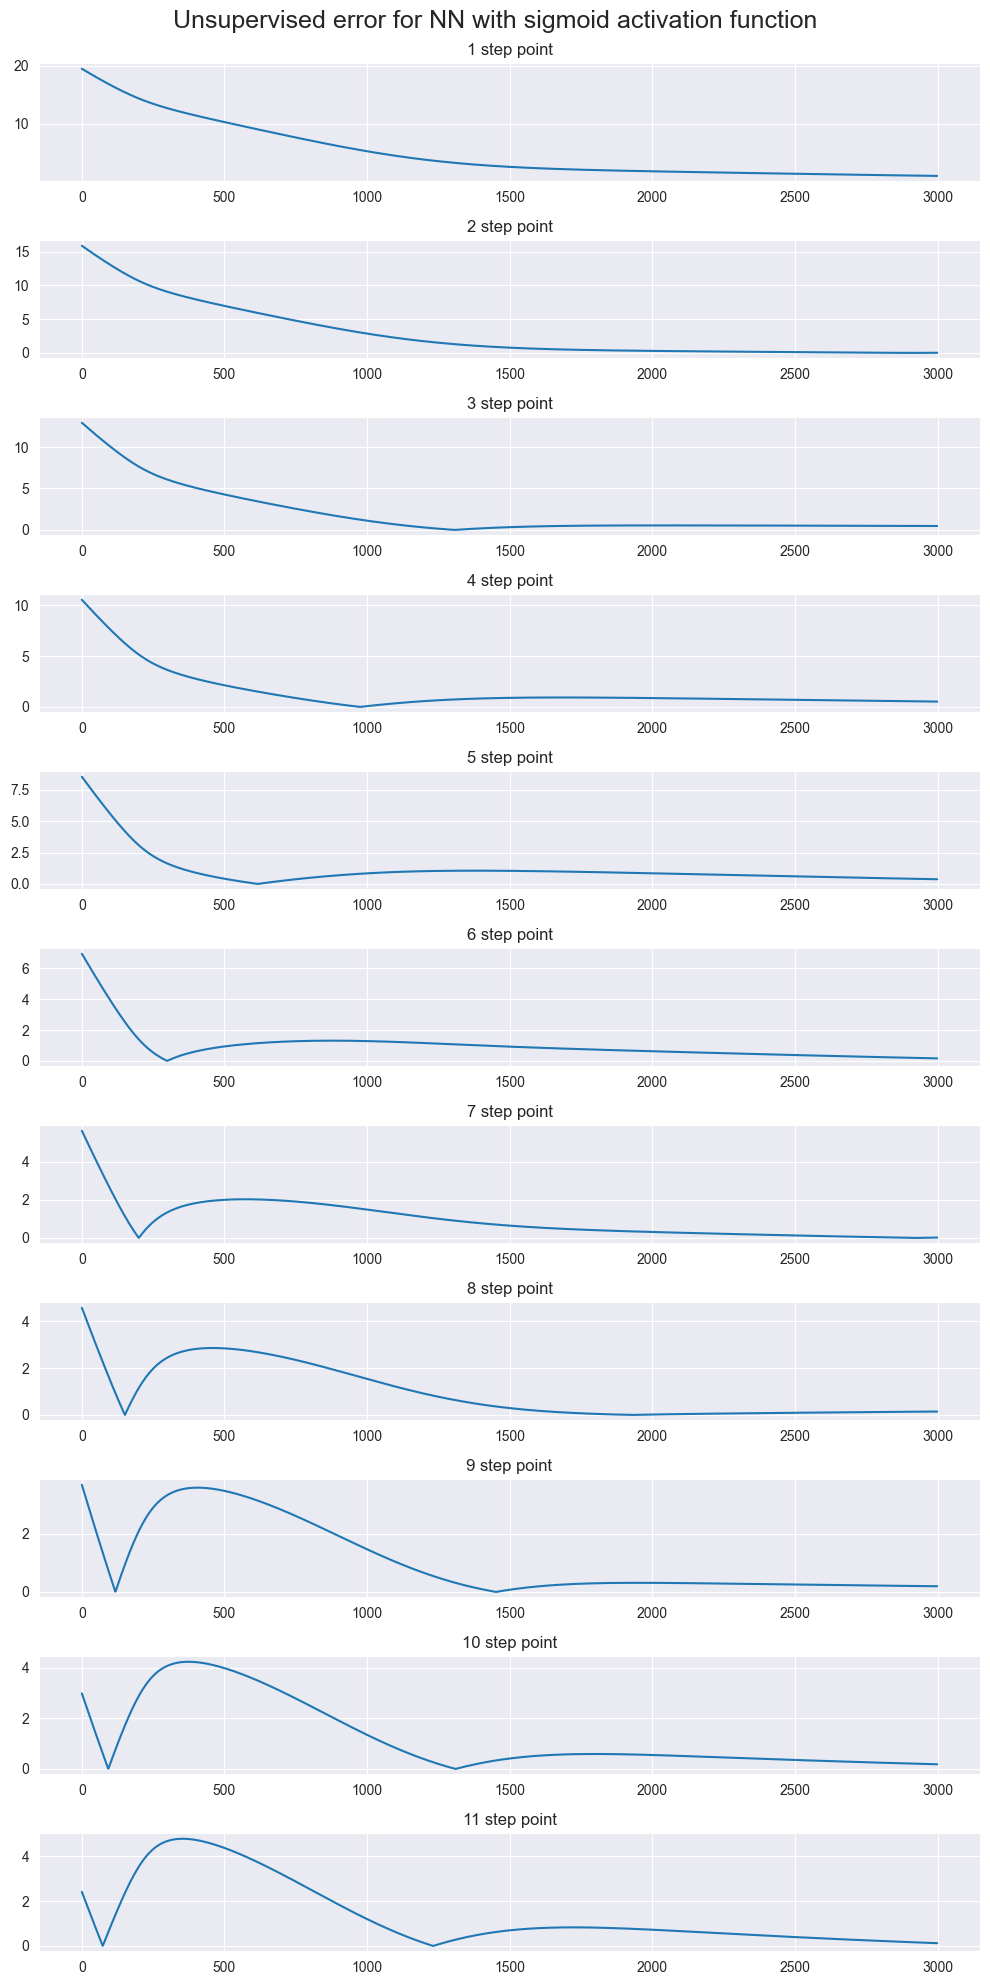

In [60]:
# number of step points
m = 11

# Create subplots
fig, axs = plt.subplots(m, figsize=(10, 20))

# Iterate over each subplot and plot the i-th element from each tensor
for i, ax in enumerate(axs):
    # Extract the i-th element from each tensor
    plot_data = [error[i].item() for error in unsupervised_error]
    
    # Plot the data on the i-th subplot
    ax.plot(plot_data)
    ax.set_title(f'{i+1} step point')
fig.suptitle('Unsupervised error for NN with sigmoid activation function', fontsize=18, x=0.5, y=0.99)
fig.tight_layout()
plt.show()

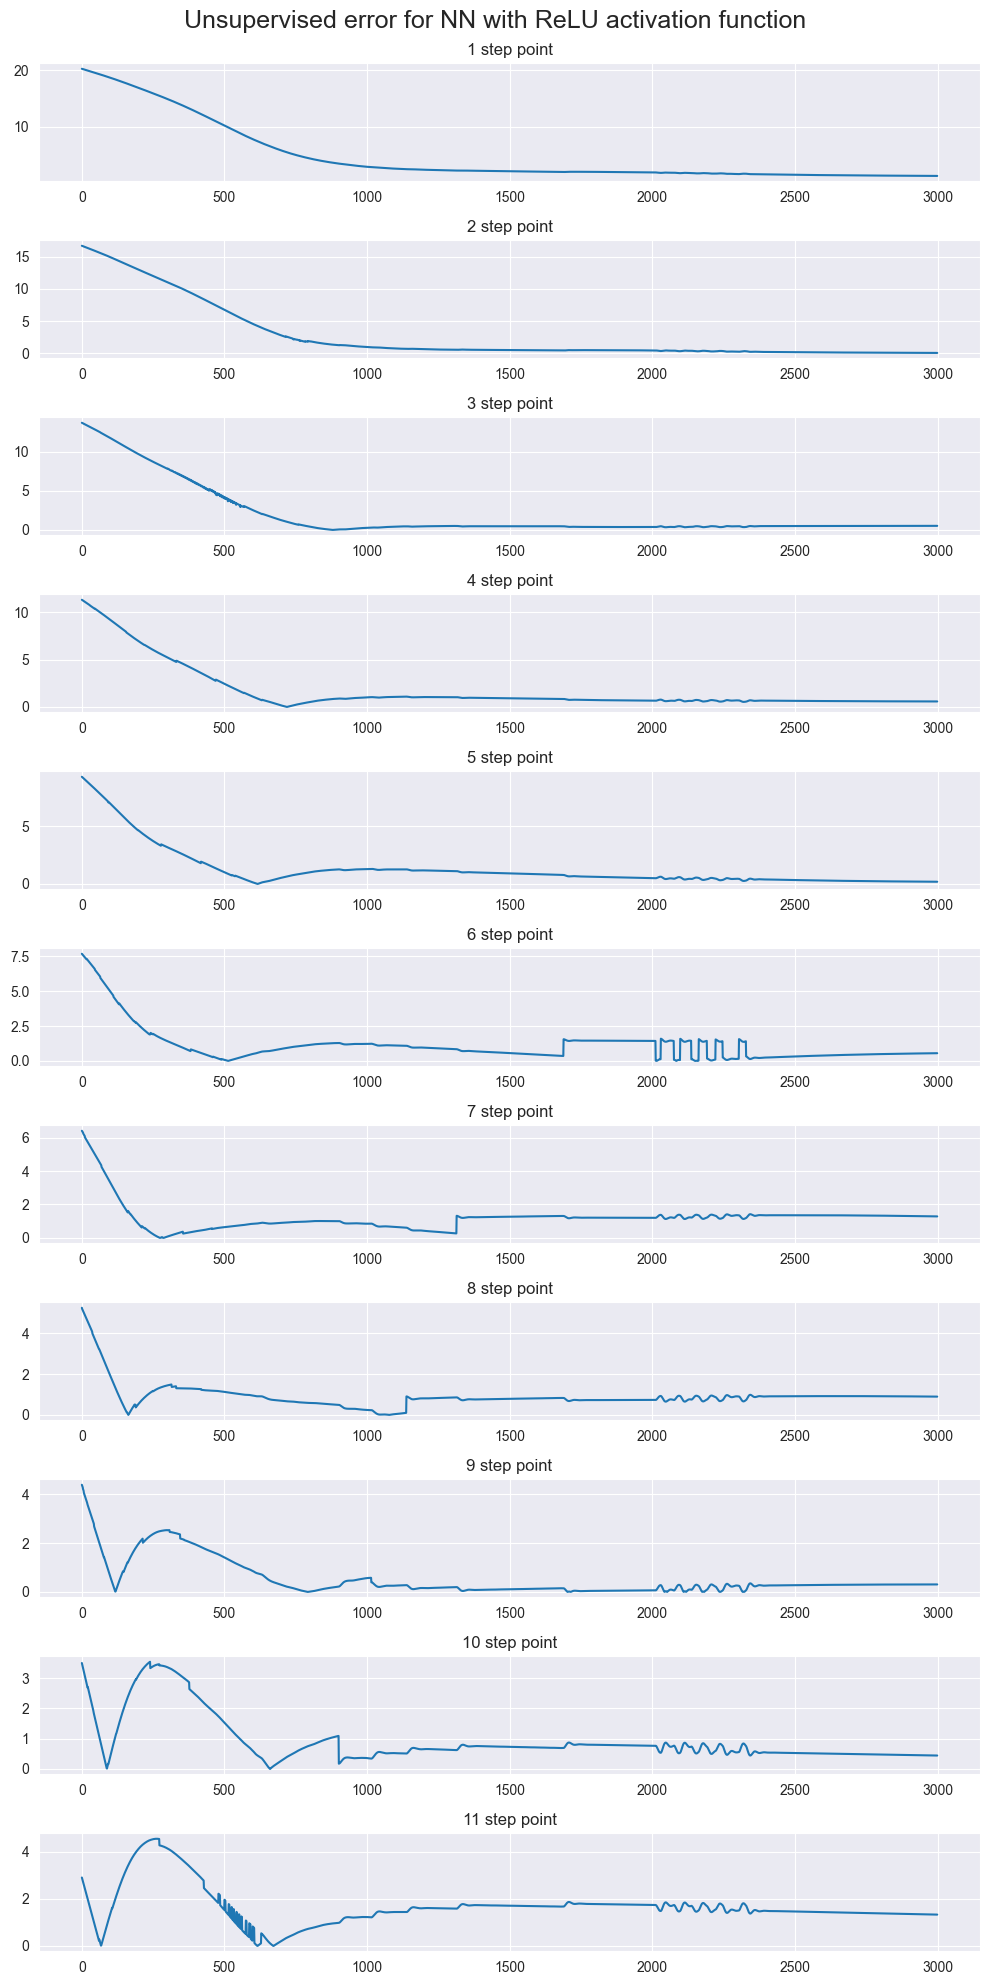

In [61]:
# number of step points
m = 11

# Create subplots
fig, axs = plt.subplots(m, figsize=(10, 20))

# Iterate over each subplot and plot the i-th element from each tensor
for i, ax in enumerate(axs):
    # Extract the i-th element from each tensor
    plot_data = [error[i].item() for error in unsupervised_error_relu]
    
    # Plot the data on the i-th subplot
    ax.plot(plot_data)
    ax.set_title(f'{i+1} step point')
fig.suptitle('Unsupervised error for NN with ReLU activation function', fontsize=18, x=0.5, y=0.99)
fig.tight_layout()
plt.show()

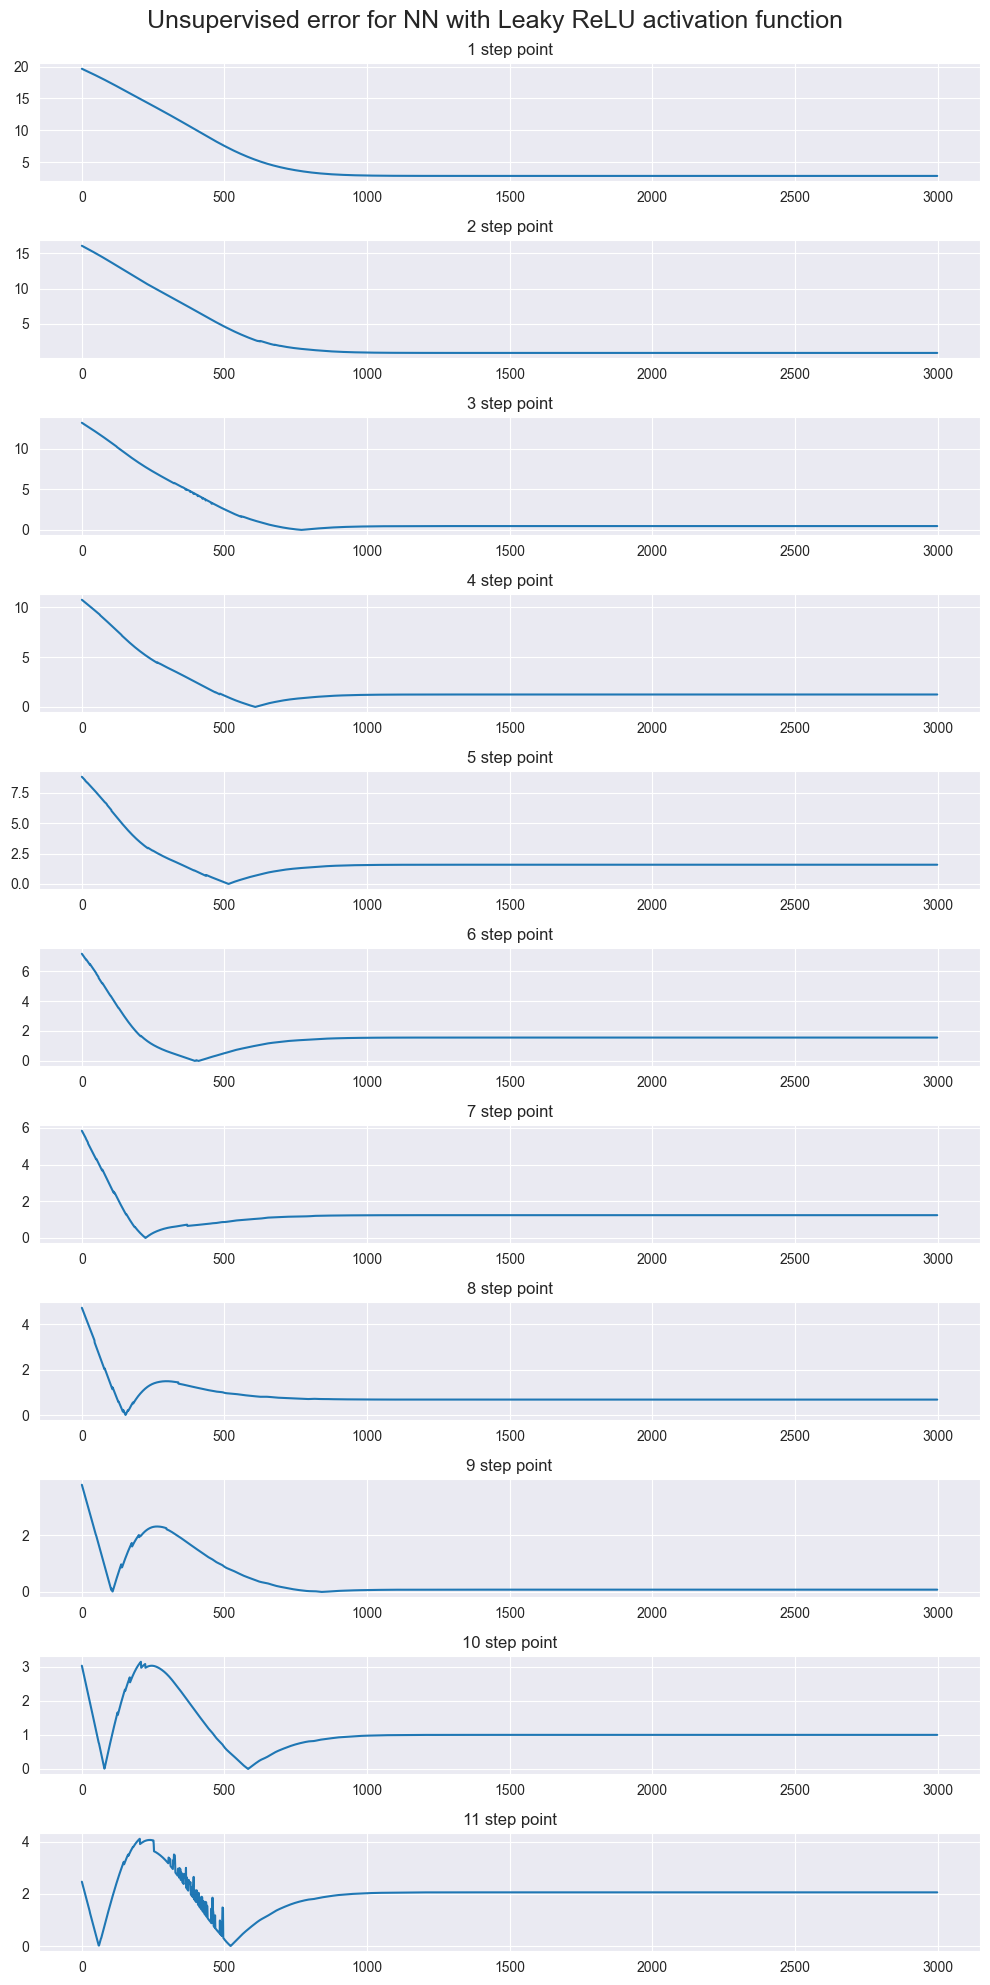

In [62]:
# number of step points
m = 11

# Create subplots
fig, axs = plt.subplots(m, figsize=(10, 20))

# Iterate over each subplot and plot the i-th element from each tensor
for i, ax in enumerate(axs):
    # Extract the i-th element from each tensor
    plot_data = [error[i].item() for error in unsupervised_error_leaky_relu]
    
    # Plot the data on the i-th subplot
    ax.plot(plot_data)
    ax.set_title(f'{i+1} step point')
fig.suptitle('Unsupervised error for NN with Leaky ReLU activation function', fontsize=18, x=0.5, y=0.99)
fig.tight_layout()
plt.show()